# Tabular Playground Series - JAN 2022: My Second Attempt

In this notebook, we will try a different approach to the Kaggle's competition [TPS JAN 2022](https://www.kaggle.com/c/tabular-playground-series-jan-2022). This time, by having a variable named GDP deflator we can calculate the sales growth rate by year, which improves the performance on unseen, incoming years. And we will have into account the holidays in the Nordic Countries in order to improve the seasonilty impact on sales. Then we will build a CatBoost Regressor model with the library PyCaret in order to test this popular tool that I just found out about.

# Feature Engineering 

In [1]:
import numpy as np 
import pandas as pd

import dateutil.easter as easter # to compute easter days
from pycaret.regression import * # import PyCaret

In [2]:
# load the data
train = pd.read_csv('train.csv', parse_dates=['date'], index_col='row_id')
test = pd.read_csv('test.csv', parse_dates=['date'], index_col='row_id')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26298 entries, 0 to 26297
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      26298 non-null  datetime64[ns]
 1   country   26298 non-null  object        
 2   store     26298 non-null  object        
 3   product   26298 non-null  object        
 4   num_sold  26298 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.2+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6570 entries, 26298 to 32867
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     6570 non-null   datetime64[ns]
 1   country  6570 non-null   object        
 2   store    6570 non-null   object        
 3   product  6570 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 256.6+ KB


In [5]:
# loading holiday data
holiday_data = pd.read_csv('holidays.csv')
holiday_data.head()

date country            event        type
0  2015-01-01  Norway   New Year's Day      public
1  2015-02-08  Norway     Mother's Day  unofficial
2  2015-02-14  Norway  Valentine's Day  unofficial
3  2015-03-20  Norway   Spring Equinox       other
4  2015-03-29  Norway      Palm Sunday  unofficial

In [6]:
# gdp data
gdp = pd.read_csv('GDP_data_2015_to_2019_Finland_Norway_Sweden.csv', index_col='year')

# renaming columns
gdp.columns = ['Finland', 'Norway', 'Sweden']
gdp

Finland   Norway   Sweden
year                           
2015  234.440  385.802  505.104
2016  240.608  368.827  515.655
2017  255.017  398.394  541.019
2018  275.580  437.000  555.455
2019  268.782  405.510  533.880

As we saw in the first attempt, the GDP plays an important role in forecasting sales. This time, we will consider the GDP deflator, which is a measure of inflation. The weight of the GDP feature, which is roughly 1.212, has a special meaning: It means that the sales of the corresponding year/country are proportional to $\text{GDP} ^{ 1.212}.$ We will apply this transformation to the response variable so that our model can be trained on this proportion, and we will also transform the response variable via the natural logarithm since the variables have a multiplicative linear relationship.

In [7]:
k_folds = 3
GDP_exponent = 1.2120618918594863 

# exponentiating the gdp values
gdp = gdp.apply(lambda x: x**GDP_exponent)


scaler = gdp.iloc[k_folds+1] / gdp
gdp_map = scaler.stack().to_dict()
gdp_map

{(2015, 'Finland'): 1.180207195768202,
 (2015, 'Norway'): 1.0622469599723645,
 (2015, 'Sweden'): 1.0694627347396386,
 (2016, 'Finland'): 1.1436370048593527,
 (2016, 'Norway'): 1.1217893946379718,
 (2016, 'Sweden'): 1.0429974555413364,
 (2017, 'Finland'): 1.0657924616373478,
 (2017, 'Norway'): 1.0216903148586545,
 (2017, 'Sweden'): 0.9840287289194982,
 (2018, 'Finland'): 0.9701796054839046,
 (2018, 'Norway'): 0.9133398129735806,
 (2018, 'Sweden'): 0.9531169609013861,
 (2019, 'Finland'): 1.0,
 (2019, 'Norway'): 1.0,
 (2019, 'Sweden'): 1.0}

With the gdp_map we've created, we will transform the column 'num_sold' by its corresponding (Year, Country) value.

In [8]:
# transforming via gdp_map
train['num_sold'] = pd.Series(list(zip(train['date'].dt.year, train['country']))).map(gdp_map) \
                    * train['num_sold']

# transforming with natural logarithm for multiplicative model
train['num_sold'] = np.log1p(train['num_sold'])

In [9]:
train.head()

date  country       store         product  num_sold
row_id                                                          
0      2015-01-01  Finland  KaggleMart      Kaggle Mug  5.964320
1      2015-01-01  Finland  KaggleMart      Kaggle Hat  6.421147
2      2015-01-01  Finland  KaggleMart  Kaggle Sticker  5.155083
3      2015-01-01  Finland  KaggleRama      Kaggle Mug  6.516309
4      2015-01-01  Finland  KaggleRama      Kaggle Hat  6.981163

Next, we want to introduce the holidays we got from holiday_data, as well as having into special consideration holidays with a greater weight. We will create a function that does this to transform both the train and test data.

In [10]:
def holiday_features(holiday_df, df):
    
    # selecting holiday rows for each country
    fin_holiday = holiday_df.loc[holiday_df['country'] == 'Finland']
    swe_holiday = holiday_df.loc[holiday_df['country'] == 'Sweden']
    nor_holiday = holiday_df.loc[holiday_df['country'] == 'Norway']
    
    # creating 3 temporary columns
    # with 1 as a value if the date belongs to a holiday
    # or 0 otherwise
    df['fin holiday'] = df['date'].isin(fin_holiday['date']).astype(int)
    df['swe holiday'] = df['date'].isin(swe_holiday['date']).astype(int)
    df['nor holiday'] = df['date'].isin(nor_holiday['date']).astype(int)
    
    # placeholder column
    df['holiday'] = np.zeros(df.shape[0]).astype(int)
    
    # using just 1 column to replace the previous 3 temporary columns, with same info
    df.loc[df['country'] == 'Finland', 'holiday'] = df.loc[df['country'] == 'Finland', 'fin holiday']
    df.loc[df['country'] == 'Sweden', 'holiday'] = df.loc[df['country'] == 'Sweden', 'swe holiday']
    df.loc[df['country'] == 'Norway', 'holiday'] = df.loc[df['country'] == 'Norway', 'nor holiday']
    
    # dropping temp columns
    df.drop(['fin holiday', 'swe holiday', 'nor holiday'], axis=1, inplace=True)
    
    # Getting Easter for every year
    easter_date = df['date'].apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    
    # calculating days from easter with boundary values lower=-5, upper=65
    df['days_from_easter'] = (df['date'] - easter_date).dt.days.clip(-5, 65)
    
    # special holidays
    
    # last wednesday of june
    wed_june_date = df['date'].dt.year.map({
        2015: pd.Timestamp(('2015-06-24')),
        2016: pd.Timestamp(('2016-06-29')),
        2017: pd.Timestamp(('2017-06-28')),
        2018: pd.Timestamp(('2018-06-27')),
        2019: pd.Timestamp(('2019-06-26'))
    })
    df['days_from_wed_jun'] = (df['date'] - wed_june_date).dt.days.clip(-5, 5)
    
    # first Sunday of November (second Sunday is Father's Day)
    sun_nov_date = df['date'].dt.year.map({
        2015: pd.Timestamp(('2015-11-1')),
        2016: pd.Timestamp(('2016-11-6')),
        2017: pd.Timestamp(('2017-11-5')),
        2018: pd.Timestamp(('2018-11-4')),
        2019: pd.Timestamp(('2019-11-3'))
    })
    df['days_from_sun_nov'] = (df['date'] - sun_nov_date).dt.days.clip(-1, 9)
    
    return df


# applying the function to both datasets

train = holiday_features(holiday_data, train)
test  = holiday_features(holiday_data, test)

In [11]:
train.head()

date  country       store         product  num_sold  holiday  \
row_id                                                                      
0      2015-01-01  Finland  KaggleMart      Kaggle Mug  5.964320        1   
1      2015-01-01  Finland  KaggleMart      Kaggle Hat  6.421147        1   
2      2015-01-01  Finland  KaggleMart  Kaggle Sticker  5.155083        1   
3      2015-01-01  Finland  KaggleRama      Kaggle Mug  6.516309        1   
4      2015-01-01  Finland  KaggleRama      Kaggle Hat  6.981163        1   

        days_from_easter  days_from_wed_jun  days_from_sun_nov  
row_id                                                          
0                     -5                 -5                 -1  
1                     -5                 -5                 -1  
2                     -5                 -5                 -1  
3                     -5                 -5                 -1  
4                     -5                 -5                 -1

Let's now one-hot encode the categorical features (product, store and country).

In [12]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

train.head()

date  num_sold  holiday  days_from_easter  days_from_wed_jun  \
row_id                                                                      
0      2015-01-01  5.964320        1                -5                 -5   
1      2015-01-01  6.421147        1                -5                 -5   
2      2015-01-01  5.155083        1                -5                 -5   
3      2015-01-01  6.516309        1                -5                 -5   
4      2015-01-01  6.981163        1                -5                 -5   

        days_from_sun_nov  country_Finland  country_Norway  country_Sweden  \
row_id                                                                       
0                      -1                1               0               0   
1                      -1                1               0               0   
2                      -1                1               0               0   
3                      -1                1               0               0   
4                      -1                1               0               0   

        store_KaggleMart  store_KaggleRama  product_Kaggle Hat  \
row_id                                                           
0                      1                 0                   0   
1                      1                 0                   1   
2                      1                 0                   0   
3                      0                 1                   0   
4                      0                 1                   1   

        product_Kaggle Mug  product_Kaggle Sticker  
row_id                                              
0                        1                       0  
1                        0                       0  
2                        0                       1  
3                        1                       0  
4                        0                       0

Now, let's extract as much information as we can from the dates as we did in the previous attempt.

In [13]:
def all_date_features(df):
    df['year'] = df['date'].dt.year 
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month  
    df['week'] = df['date'].dt.week 
    df['day'] = df['date'].dt.day  
    df['weekday'] = df['date'].dt.weekday
    df['day_of_week'] = df['date'].dt.dayofweek  
    df['day_of_year'] = df['date'].dt.dayofyear  
    df['week_of_year'] = df['date'].dt.weekofyear
    df['day_of_month'] = df['date'].dt.days_in_month  
    df['is_weekend'] = np.where((df['weekday'] == 5) | (df['weekday'] == 6), 1, 0)
    df['is_friday'] = np.where((df['weekday'] == 4), 1, 0)
    
    df.drop('date', axis=1, inplace=True)
    
    return df
    
train = all_date_features(train)
test  = all_date_features(test)

# Model Building with PyCaret

First, let's define the SPAME metric.

In [14]:
def smape(actual, predicted):
    numerator = np.abs(predicted - actual)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    
    return np.mean(numerator / denominator)*100

We will use PyCaret to build a CatBoost Regressor model. According to its own [documentation page](https://pycaret.gitbook.io/docs/):

- PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that exponentially speeds up the experiment cycle and makes you more productive.

To initialize the model, we will use the setup() function:

- The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline.

In [15]:
models = []

for i in range(3):
    print ('Fiting Model', i)
    reg = setup(
        data = train,
        target = 'num_sold',
        data_split_shuffle = False, 
        create_clusters = False,
        fold_strategy = 'groupkfold',
        fold_groups = 'year',
        silent = True,
        fold = k_folds,
        n_jobs = -1,
    )
    
    add_metric('SMAPE', 'SMAPE', smape, greater_is_better=False)
    
    models.append(create_model('catboost'))

## Importance feature with PyCaret

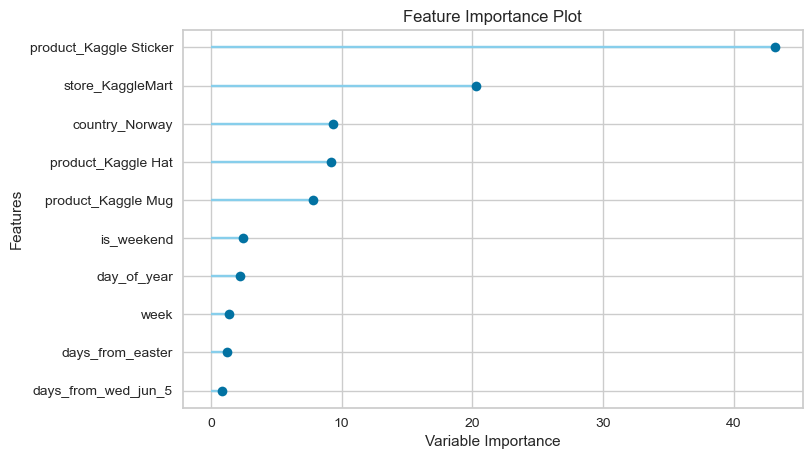

In [16]:
plot_model(models[0], 'feature')

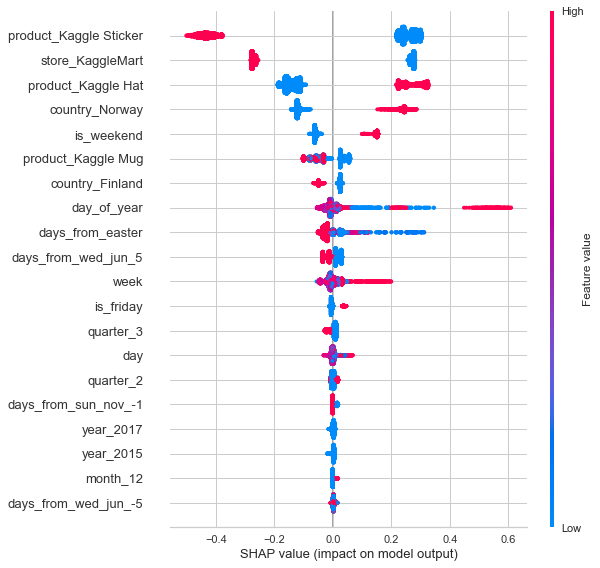

In [17]:
# Getting SHAP values
interpret_model(models[0])

In [18]:
blend = blend_models(models)

In [19]:
final_blend = finalize_model(blend)

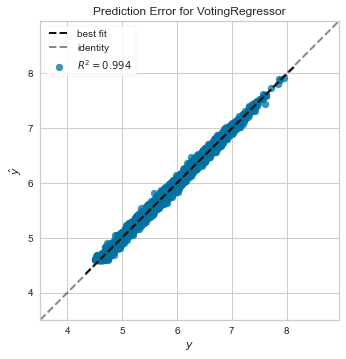

In [20]:
plot_model(final_blend, 'error')

In [21]:
# getting predictions for the test set
# remember to use the exponential function to inverse-transform the response variable
y_pred = np.expm1(predict_model(final_blend, data=test)['Label'])

y_pred

row_id
26298     367.131585
26299     570.934132
26300     162.728215
26301     642.799972
26302     994.561420
            ...     
32863     837.602851
32864     248.641548
32865     958.983624
32866    1431.025114
32867     408.202906
Name: Label, Length: 6570, dtype: float64

# Submitting to Kaggle

Finally, we submit the predictions to Kaggle so that we get a score.

In [22]:
submission = pd.read_csv('sample_submission.csv')
submission['num_sold'] = y_pred.values

submission.to_csv('submission.csv', index=False)

submission

row_id     num_sold
0      26298   367.131585
1      26299   570.934132
2      26300   162.728215
3      26301   642.799972
4      26302   994.561420
...      ...          ...
6565   32863   837.602851
6566   32864   248.641548
6567   32865   958.983624
6568   32866  1431.025114
6569   32867   408.202906

[6570 rows x 2 columns]

Let's check the result after uploading it:

![alt text](2nd_SCORE.jpg "Title")

![alt text](2nd_SCORE_TABLE.jpg "Title")

This is very nice improvement from the previous score. 

We're now in the place 153 out of 1429 participants, which means we're almost among the 10% best scores.

# Visualizing Forecasting on 2018

In [28]:
train20152017 = train[train['year']<2018]

In [29]:
train20152017

num_sold  holiday  days_from_easter  days_from_wed_jun  \
row_id                                                           
0       5.964320        1                -5                 -5   
1       6.421147        1                -5                 -5   
2       5.155083        1                -5                 -5   
3       6.516309        1                -5                 -5   
4       6.981163        1                -5                 -5   
...          ...      ...               ...                ...   
19723   6.928967        1                65                  5   
19724   5.657279        1                65                  5   
19725   7.064781        1                65                  5   
19726   7.469401        1                65                  5   
19727   6.258692        1                65                  5   

        days_from_sun_nov  country_Finland  country_Norway  country_Sweden  \
row_id                                                                       
0                      -1                1               0               0   
1                      -1                1               0               0   
2                      -1                1               0               0   
3                      -1                1               0               0   
4                      -1                1               0               0   
...                   ...              ...             ...             ...   
19723                   9                0               0               1   
19724                   9                0               0               1   
19725                   9                0               0               1   
19726                   9                0               0               1   
19727                   9                0               0               1   

        store_KaggleMart  store_KaggleRama  ...  month  week  day  weekday  \
row_id                                      ...                              
0                      1                 0  ...      1     1    1        3   
1                      1                 0  ...      1     1    1        3   
2                      1                 0  ...      1     1    1        3   
3                      0                 1  ...      1     1    1        3   
4                      0                 1  ...      1     1    1        3   
...                  ...               ...  ...    ...   ...  ...      ...   
19723                  1                 0  ...     12    52   31        6   
19724                  1                 0  ...     12    52   31        6   
19725                  0                 1  ...     12    52   31        6   
19726                  0                 1  ...     12    52   31        6   
19727                  0                 1  ...     12    52   31        6   

        day_of_week  day_of_year  week_of_year  day_of_month  is_weekend  \
row_id                                                                     
0                 3            1             1            31           0   
1                 3            1             1            31           0   
2                 3            1             1            31           0   
3                 3            1             1            31           0   
4                 3            1             1            31           0   
...             ...          ...           ...           ...         ...   
19723             6          365            52            31           1   
19724             6          365            52            31           1   
19725             6          365            52            31           1   
19726             6          365            52            31           1   
19727             6          365            52            31           1   

        is_friday  
row_id             
0               0  
1               0  
2               0  
3               0  
4         

In [30]:
test2018 = train20152017 = train[train['year']==2018]

In [31]:
test2018

num_sold  holiday  days_from_easter  days_from_wed_jun  \
row_id                                                           
19728   5.976155        1                -5                 -5   
19729   6.402715        1                -5                 -5   
19730   5.146049        1                -5                 -5   
19731   6.542051        1                -5                 -5   
19732   6.920570        1                -5                 -5   
...          ...      ...               ...                ...   
26293   6.666213        1                65                  5   
26294   5.477631        1                65                  5   
26295   6.864774        1                65                  5   
26296   7.225803        1                65                  5   
26297   5.915688        1                65                  5   

        days_from_sun_nov  country_Finland  country_Norway  country_Sweden  \
row_id                                                                       
19728                  -1                1               0               0   
19729                  -1                1               0               0   
19730                  -1                1               0               0   
19731                  -1                1               0               0   
19732                  -1                1               0               0   
...                   ...              ...             ...             ...   
26293                   9                0               0               1   
26294                   9                0               0               1   
26295                   9                0               0               1   
26296                   9                0               0               1   
26297                   9                0               0               1   

        store_KaggleMart  store_KaggleRama  ...  month  week  day  weekday  \
row_id                                      ...                              
19728                  1                 0  ...      1     1    1        0   
19729                  1                 0  ...      1     1    1        0   
19730                  1                 0  ...      1     1    1        0   
19731                  0                 1  ...      1     1    1        0   
19732                  0                 1  ...      1     1    1        0   
...                  ...               ...  ...    ...   ...  ...      ...   
26293                  1                 0  ...     12     1   31        0   
26294                  1                 0  ...     12     1   31        0   
26295                  0                 1  ...     12     1   31        0   
26296                  0                 1  ...     12     1   31        0   
26297                  0                 1  ...     12     1   31        0   

        day_of_week  day_of_year  week_of_year  day_of_month  is_weekend  \
row_id                                                                     
19728             0            1             1            31           0   
19729             0            1             1            31           0   
19730             0            1             1            31           0   
19731             0            1             1            31           0   
19732             0            1             1            31           0   
...             ...          ...           ...           ...         ...   
26293             0          365             1            31           0   
26294             0          365             1            31           0   
26295             0          365             1            31           0   
26296             0          365             1            31           0   
26297             0          365             1            31           0   

        is_friday  
row_id             
19728           0  
19729           0  
19730           0  
19731           0  
19732     

In [32]:
pred2018 = np.expm1(predict_model(final_blend, data=train20152017)['Label'])

In [33]:
pred2018

row_id
19728     381.617223
19729     590.322950
19730     169.104813
19731     668.170540
19732    1028.417905
            ...     
26293     807.428910
26294     237.927077
26295     915.867834
26296    1370.846782
26297     388.041994
Name: Label, Length: 6570, dtype: float64

In [35]:
test2018['num_sold'].apply(np.expm1)

row_id
19728     392.922740
19729     602.481535
19730     170.751611
19731     692.708238
19732    1011.897329
            ...     
26293     784.415259
26294     238.279240
26295     956.929429
26296    1373.441541
26297     369.809381
Name: num_sold, Length: 6570, dtype: float64

In [36]:
# getting dates 
train_copy = pd.read_csv('train.csv', parse_dates=['date'])
dates2018 = train_copy[train_copy['date'].dt.year == 2018]['date']

In [37]:
dates2018

19728   2018-01-01
19729   2018-01-01
19730   2018-01-01
19731   2018-01-01
19732   2018-01-01
           ...    
26293   2018-12-31
26294   2018-12-31
26295   2018-12-31
26296   2018-12-31
26297   2018-12-31
Name: date, Length: 6570, dtype: datetime64[ns]

In [38]:
dt_2018 = pd.DataFrame({'True num_sold':test2018['num_sold'].apply(np.expm1),
                        'Predicted num_sold': pred2018.values})

In [41]:
dt_2018.index = dates2018

In [42]:
dt_2018

True num_sold  Predicted num_sold
date                                         
2018-01-01     392.922740          381.617223
2018-01-01     602.481535          590.322950
2018-01-01     170.751611          169.104813
2018-01-01     692.708238          668.170540
2018-01-01    1011.897329         1028.417905
...                   ...                 ...
2018-12-31     784.415259          807.428910
2018-12-31     238.279240          237.927077
2018-12-31     956.929429          915.867834
2018-12-31    1373.441541         1370.846782
2018-12-31     369.809381          388.041994

[6570 rows x 2 columns]

In [88]:
months2018 = []
months_names = ['January', 'February', 'March', 'April',
                'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December']

for i in range(1,13):

    month = [day for day in dt_2018.index if day.month==i]
    months2018.append(month)

In [59]:
import matplotlib.pyplot as plt

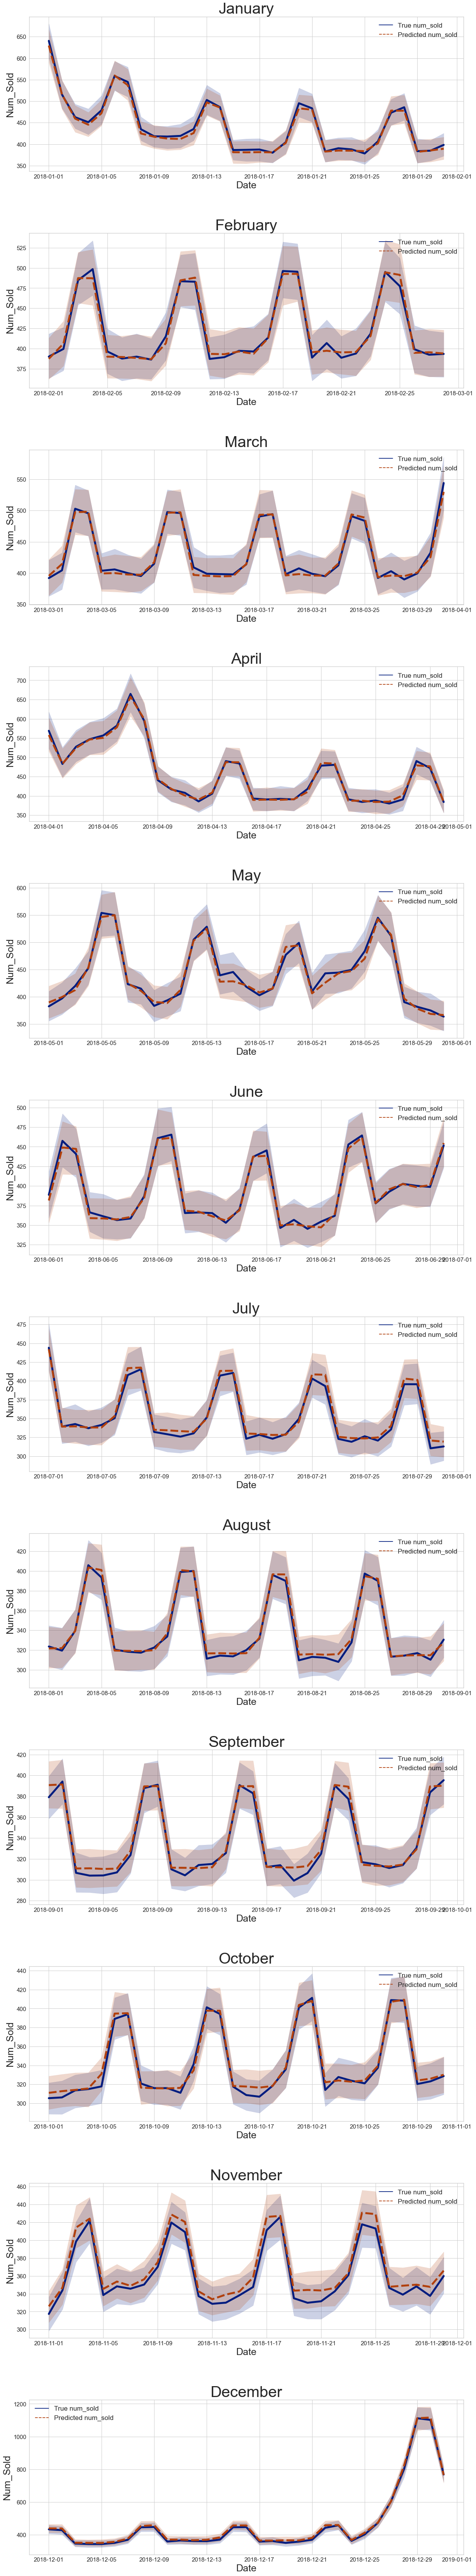

In [113]:
fig, axes = plt.subplots(12, 1, figsize=(20, 120))

for i in range(0,12):

    b=sns.lineplot(ax=axes[i], data=dt_2018.loc[months2018[i]], linewidth = 5, palette='dark')
    b.axes.set_title(months_names[i], fontsize=40)
    b.axes.legend(fontsize='x-large')
    b.axes.tick_params(axis='both', which='major', labelsize=15)
    b.axes.tick_params(axis='both', which='minor', labelsize=15)
    b.axes.set_xlabel('Date', fontsize = 25)
    b.axes.set_ylabel('Num_Sold', fontsize = 25)
    
fig.subplots_adjust(hspace=.4);